In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns


# Import Data


In [7]:
training_data = pd.read_csv("PastLoans.csv")
prediction_data = pd.read_csv("NewApplications_Lender3_Round2.csv")

In [10]:
training_data = training_data.drop(["digital1", "digital2"], axis=1)
training_data.head()

,sex,employment,married,income,digital3,default
0,M,unemployed,0,0,0.738735,0
1,M,employed,1,26108,0.733947,0
2,M,employed,1,11810,0.000000,0
3,M,unemployed,1,0,0.000000,0
4,F,retired,1,6310,0.203202,0


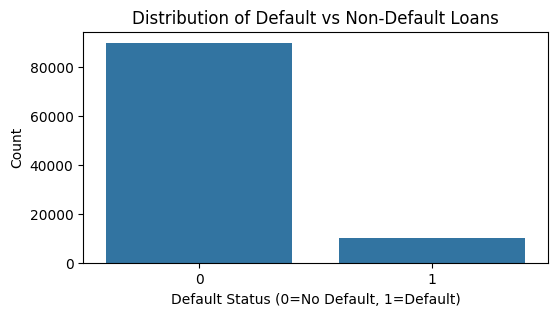

In [15]:
plt.figure(figsize=(6, 3))
sns.countplot(data=training_data, x='default')
plt.title('Distribution of Default vs Non-Default Loans')
plt.xlabel('Default Status (0=No Default, 1=Default)')
plt.ylabel('Count')
plt.show()

# Heavely unbalanced dataset

In [16]:
X = training_data.drop(["default"], axis=1)
y = training_data["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



use class weights to deal with unbalanced dataset

In [17]:
# Calculate class weights (will give more importance to defaults)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',
                                   classes=np.unique(training_data['default']),
                                   y=training_data['default'])
class_weight_dict = dict(zip(np.unique(training_data['default']), class_weights))



# For XGBoost
xgb_model = XGBClassifier(scale_pos_weight=class_weights[1]/class_weights[0])

# For Logistic Regression
lr_model = LogisticRegression(class_weight=class_weight_dict)

# For Neural Network
class_weight_dict_float = {k: float(v) for k, v in class_weight_dict.items()}
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Train and evaluate models
from sklearn.metrics import recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

# Train models
xgb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train, epochs=10, class_weight=class_weight_dict_float, verbose=0)

# Get predictions
models = {
    'XGBoost': xgb_model,
    'Logistic Regression': lr_model, 
    'Neural Network': nn_model
}

metrics = {
    'Recall': [],
    'Precision': [],
    'F1 Score': []
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    if name == 'Neural Network':
        y_pred = (y_pred > 0.5).astype(int)
    
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred))
    metrics['F1 Score'].append(f1_score(y_test, y_pred))

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:sex: object, employment: object

In [ ]:
# Plot results
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, metrics['Recall'], width, label='Recall')
ax.bar(x, metrics['Precision'], width, label='Precision')
ax.bar(x + width, metrics['F1 Score'], width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models.keys())
ax.legend()

plt.tight_layout()
plt.show()